# Creating a Bar Chart Race Animation with Matplotlib

In this tutorial, you'll learn how to create a bar chart race animation such as the one below using the matplotlib data visualization library in python.

![bar chart race][0]

### `bar_chart_race` python package

Along with this tutorial is the release of the python package `bar_chart_race` that automates the process of making these animations. This post explains the procedure from scratch.

### What is a bar chart race?

A bar chart race is an animated sequence of bars that show data values at different moments in time. The bars re-position themselves at each time period so that they remain in order (either ascending or descending).

## Transition bars smoothly between time periods

The trick to making a bar chart race is to transition the bars slowly to their new position when their order changes, allowing you to easily track the movements.

### COVID-19 deaths data

For this bar chart race, we'll use a small dataset produced by John Hopkins University containing the total deaths by date for six countries during the currently ongoing coronavirus pandemic. Let's read it in now.

[0]: media/covid19.png

In [1]:
import pandas as pd
df = pd.read_csv('data/covid19.csv', index_col='date', parse_dates=['date'])
df.tail()

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-04-18,4636.0,38671.0,23227.0,15498.0,5031.0,20043.0
2020-04-19,4636.0,40664.0,23660.0,16095.0,5118.0,20453.0
2020-04-20,4636.0,42097.0,24114.0,16550.0,5209.0,20852.0
2020-04-21,4636.0,44447.0,24648.0,17378.0,5297.0,21282.0
2020-04-22,4636.0,46628.0,25085.0,18151.0,5391.0,21717.0


### Must use 'wide' data

For this tutorial, the data must be in 'wide' form where:

* Every row represents a single period of time
* Each column holds the value for a particular category
* The index contains the time component (optional)

### Individual bar charts for specific dates

Let's begin by creating a single static bar chart for the specific date of March 29, 2020. First, we select the data as a Series.

In [2]:
s = df.loc['2020-03-29']
s

China     3304.0
USA       2566.0
Italy    10779.0
UK        1231.0
Iran      2640.0
Spain     6803.0
Name: 2020-03-29 00:00:00, dtype: float64

We'll make a horizontal bar chart using the country names as the y-values and total deaths as the x-values (width of bars). Every bar will be a different color from the 'Dark2' colormap.

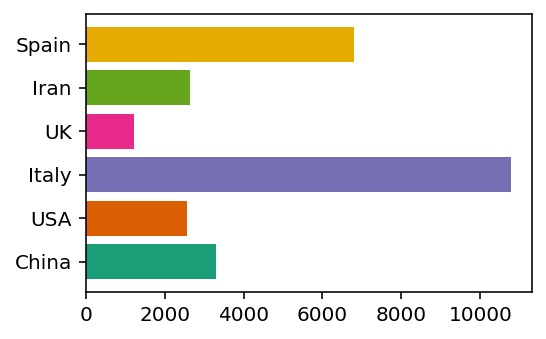

In [3]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4, 2.5), dpi=144)
colors = plt.cm.Dark2(range(6))
y = s.index
width = s.values
ax.barh(y=y, width=width, color=colors);

The function below changes several properties of the axes to make it look nicer.

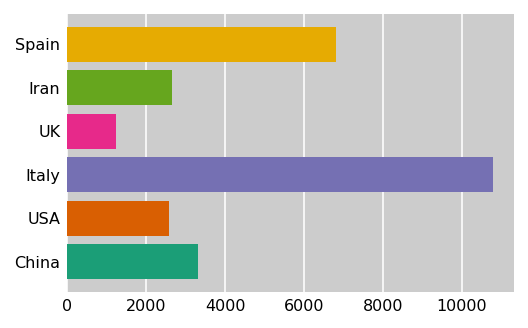

In [4]:
def nice_axes(ax):
    ax.set_facecolor('.8')
    ax.tick_params(labelsize=8, length=0)
    ax.grid(True, axis='x', color='white')
    ax.set_axisbelow(True)
    [spine.set_visible(False) for spine in ax.spines.values()]
    
nice_axes(ax)
fig

### Plot three consecutive days ordering the bars

For a bar chart race, the bars are often ordered from largest to smallest with the largest at the top. Here, we plot three days of data sorting each one first.

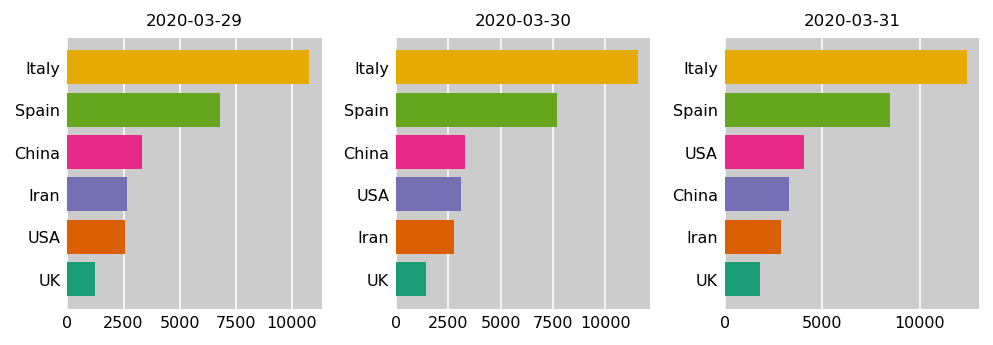

In [5]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-03-29', '2020-03-30', '2020-03-31']
for ax, date in zip(ax_array, dates):
    s = df.loc[date].sort_values()
    ax.barh(y=s.index, width=s.values, color=colors)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

### Countries change color

Although the bars are ordered properly, the countries do not keep their original color when changing places in the graph. Notice that the USA begins as the fifth bar and moves up one position each date, changing colors each time.

### Don't sort - rank instead!

Instead of sorting, use the `rank` method to find the numeric ranking of each country for each day. We use the `'first'` method of ranking so that each numeric rank is a unique integer. By default, the method is `'average'` which ranks ties with the same value causing overlapping bars. Let's see the ranking for the March 29, 2020.

In [6]:
df.loc['2020-03-29'].rank(method='first')

China    4.0
USA      2.0
Italy    6.0
UK       1.0
Iran     3.0
Spain    5.0
Name: 2020-03-29 00:00:00, dtype: float64

We now use this rank as the y-values. The order of the data in the Series never changes this way, ensuring that countries remain the same color regardless of their rank.

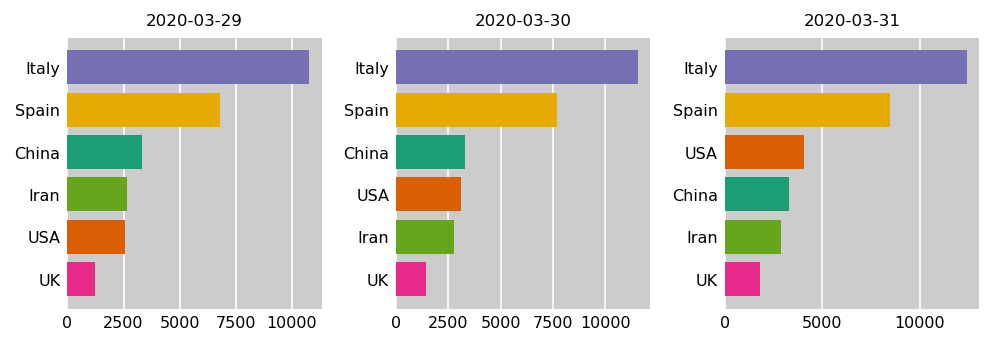

In [7]:
fig, ax_array = plt.subplots(nrows=1, ncols=3, figsize=(7, 2.5), dpi=144, tight_layout=True)
dates = ['2020-03-29', '2020-03-30', '2020-03-31']
for ax, date in zip(ax_array, dates):
    s = df.loc[date]
    y = df.loc[date].rank(method='first').values
    ax.barh(y=y, width=s.values, color=colors, tick_label=s.index)
    ax.set_title(date, fontsize='smaller')
    nice_axes(ax)

### How to smoothly transition?

Using each day as a single frame in an animation won't work well as it doesn't capture the transition from one time period to the next. In order to transition the bars that change positions, we'll need to add extra rows of data between the dates that we do have. Let's first select the three dates above as a DataFrame.

In [8]:
df2 = df.loc['2020-03-29':'2020-03-31']
df2

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-31,3309.0,4039.0,12428.0,1793.0,2898.0,8464.0


It's easier to insert an exact number of new rows when using the default index - integers beginning at 0. Alternatively, if you do have a datetime in the index as we do here, you can use the `asfreq` method, which is explained at the end of this post. Use the `reset_index` method to get a default index and to place the dates as a column again.

In [9]:
df2 = df2.reset_index()
df2

,date,China,USA,Italy,UK,Iran,Spain
0,2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
1,2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2,2020-03-31,3309.0,4039.0,12428.0,1793.0,2898.0,8464.0


### Choose number of steps between each date

We want to insert new rows between the first and second rows and between the second and third rows. Begin by multiplying the index by the number of steps to transition from one time period to the next. We use 5 in this example.

In [10]:
df2.index = df2.index * 5
df2

,date,China,USA,Italy,UK,Iran,Spain
0,2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
5,2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
10,2020-03-31,3309.0,4039.0,12428.0,1793.0,2898.0,8464.0


### Expand DataFrame with `reindex`

To insert the additional rows, pass the `reindex` method a sequence of all integers beginning at 0 to the last integer (10 in this case). pandas inserts new rows of all missing values for every index not in the current DataFrame.

In [11]:
last_idx = df2.index[-1] + 1
df_expanded = df2.reindex(range(last_idx))
df_expanded

,date,China,USA,Italy,UK,Iran,Spain
0,2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
6,NaT,NaN,NaN,NaN,NaN,NaN,NaN
7,NaT,NaN,NaN,NaN,NaN,NaN,NaN
8,NaT,NaN,NaN,NaN,NaN,NaN,NaN
9,NaT,NaN,NaN,NaN,NaN,NaN,NaN


The date for the missing rows is the same for each. Let's fill them in using the last known value with the `fillna` method and set it as the index again.

In [12]:
df_expanded['date'] = df_expanded['date'].fillna(method='ffill')
df_expanded = df_expanded.set_index('date')
df_expanded

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN


### Rank each row

We also need a similar DataFrame that contains the rank of each country by row. Most pandas methods work down each column by default. Set `axis` to 1 to change the direction of the operation so that values in each row are ranked against each other.

In [13]:
df_rank_expanded = df_expanded.rank(axis=1, method='first')
df_rank_expanded

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,4.0,2.0,6.0,1.0,3.0,5.0
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,4.0,3.0,6.0,1.0,2.0,5.0
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30,NaN,NaN,NaN,NaN,NaN,NaN


### Linear interpolate missing values

The `interpolate` method can fill in the missing values in a variety of ways. By default, it uses linear interpolation and works column-wise.

In [14]:
df_expanded = df_expanded.interpolate()
df_expanded

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-29,3304.8,2675.2,10941.4,1267.0,2663.4,6985.6
2020-03-29,3305.6,2784.4,11103.8,1303.0,2686.8,7168.2
2020-03-29,3306.4,2893.6,11266.2,1339.0,2710.2,7350.8
2020-03-29,3307.2,3002.8,11428.6,1375.0,2733.6,7533.4
2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-30,3308.2,3297.4,11758.4,1487.4,2785.2,7865.6
2020-03-30,3308.4,3482.8,11925.8,1563.8,2813.4,8015.2
2020-03-30,3308.6,3668.2,12093.2,1640.2,2841.6,8164.8


We also need to interpolate the ranking.

In [15]:
df_rank_expanded = df_rank_expanded.interpolate()
df_rank_expanded

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,4.0,2.0,6.0,1.0,3.0,5.0
2020-03-29,4.0,2.2,6.0,1.0,2.8,5.0
2020-03-29,4.0,2.4,6.0,1.0,2.6,5.0
2020-03-29,4.0,2.6,6.0,1.0,2.4,5.0
2020-03-29,4.0,2.8,6.0,1.0,2.2,5.0
2020-03-30,4.0,3.0,6.0,1.0,2.0,5.0
2020-03-30,3.8,3.2,6.0,1.0,2.0,5.0
2020-03-30,3.6,3.4,6.0,1.0,2.0,5.0
2020-03-30,3.4,3.6,6.0,1.0,2.0,5.0


### Plot each step of the transition

The interpolated ranks will serve as the new position of the bars along the y-axis. Here, we'll plot each step from the first to the second day where Iran and the USA change place.

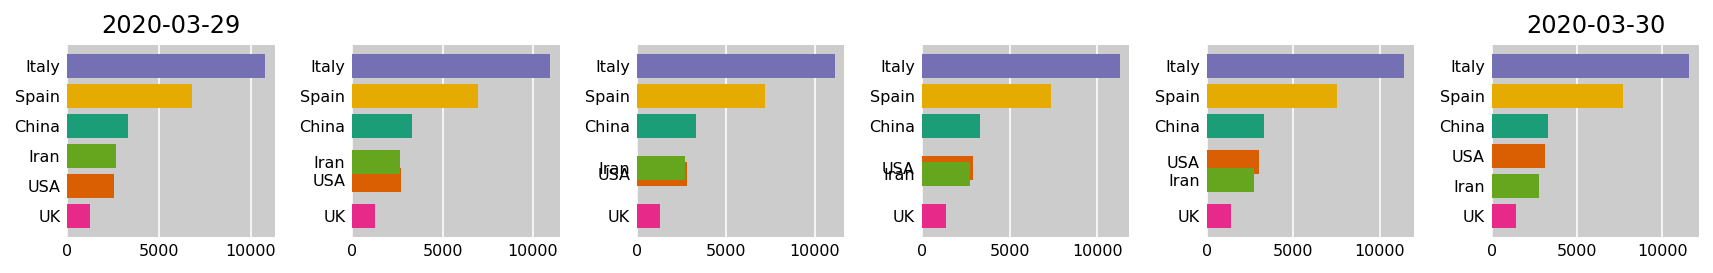

In [16]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 2), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten()):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-03-29')
ax_array[-1].set_title('2020-03-30');

The next day's transition is plotted below.

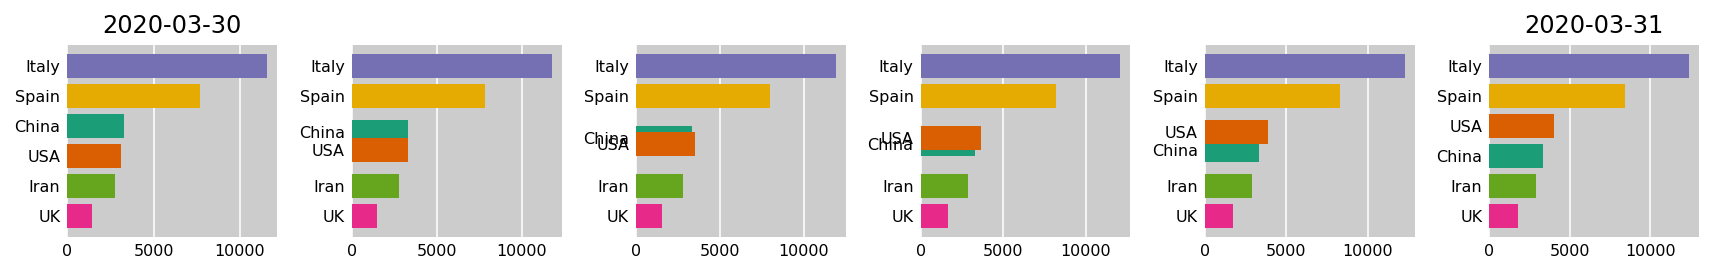

In [17]:
fig, ax_array = plt.subplots(nrows=1, ncols=6, figsize=(12, 2), 
                             dpi=144, tight_layout=True)
labels = df_expanded.columns
for i, ax in enumerate(ax_array.flatten(), start=5):
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    nice_axes(ax)
ax_array[0].set_title('2020-03-30')
ax_array[-1].set_title('2020-03-31');

### Write a function to prepare all of the data

We can copy and paste the code above into a function to automate the process of preparing any data for the bar chart race. Then use it to create the two final DataFrames needed for plotting.

In [18]:
def prepare_data(df, steps=5):
    df = df.reset_index()
    df.index = df.index * steps
    last_idx = df.index[-1] + 1
    df_expanded = df.reindex(range(last_idx))
    df_expanded['date'] = df_expanded['date'].fillna(method='ffill')
    df_expanded = df_expanded.set_index('date')
    df_rank_expanded = df_expanded.rank(axis=1, method='first')
    df_expanded = df_expanded.interpolate()
    df_rank_expanded = df_rank_expanded.interpolate()
    return df_expanded, df_rank_expanded

df_expanded, df_rank_expanded = prepare_data(df)
df_expanded.head()

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-02-26,2717.0,NaN,12.0,NaN,19.0,NaN
2020-02-26,2722.8,NaN,13.0,NaN,20.4,NaN
2020-02-26,2728.6,NaN,14.0,NaN,21.8,NaN
2020-02-26,2734.4,NaN,15.0,NaN,23.2,NaN
2020-02-26,2740.2,NaN,16.0,NaN,24.6,NaN


In [19]:
df_rank_expanded.head()

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-02-26,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26,3.0,NaN,1.0,NaN,2.0,NaN


## Animation

We are now ready to create the animation. Each row represents a single frame in our animation and will slowly transition the bars y-value location and width from one day to the next. 

The simplest way to do animation in matplotlib is to use `FuncAnimation`. You must define a function that updates the matplotlib axes object each frame. Because the axes object keeps all of the previous bars, we remove them in the beginning of the `update` function. The rest of the function is identical to the plotting from above. This function will be passed the index of the frame as an integer. We also set the title to have the current date.

Optionally, you can define a function that initializes the axes. Below, `init` clears the previous axes of all objects and then resets it's nice properties.

Pass the figure (containing your axes), the `update` and `init` functions, and number of frames to `FuncAnimation`. We also pass the number of milliseconds between each frame, which is used when creating HTML. We use 100 milliseconds per frame equating to 500 per day (half of a second).

The figure and axes are created separately below so they do not get output in a Jupyter Notebook, which automatically happens if you call `plt.subplots`.

In [20]:
from matplotlib.animation import FuncAnimation

def init():
    ax.clear()
    nice_axes(ax)
    ax.set_ylim(.2, 6.8)

def update(i):
    for bar in ax.containers:
        bar.remove()
    y = df_rank_expanded.iloc[i]
    width = df_expanded.iloc[i]
    ax.barh(y=y, width=width, color=colors, tick_label=labels)
    date_str = df_expanded.index[i].strftime('%B %-d, %Y')
    ax.set_title(f'COVID-19 Deaths by Country - {date_str}', fontsize='smaller')
    
fig = plt.Figure(figsize=(4, 2.5), dpi=144)
ax = fig.add_subplot()
anim = FuncAnimation(fig=fig, func=update, init_func=init, frames=len(df_expanded), 
                     interval=100, repeat=False)

### Return animation HTML or save to disk

Call the `to_html5_video` method to return the animation as an HTML string and then embed it in the notebook with help from the `IPython.display` module.

In [21]:
from IPython.display import HTML
html = anim.to_html5_video()
HTML(html)

You can save the animation to disk as an mp4 file using the `save` method. Since we have an `init` function, we don't have to worry about clearing our axes and resetting the limits. It will do it for us.

In [22]:
anim.save('media/covid19.mp4')

## Using `bar_chart_race`

I created the `bar_chart_race` python package to automate this process. It creates bar chart races from wide pandas DataFrames. Install with `pip install bar_chart_race`.

In [23]:
import bar_chart_race as bcr
bcr.bar_chart_race(df.iloc[30:40], steps_per_period=5, 
                          figsize=(4, 2.5), title='COVID-19 Deaths by Country')

/Users/teddy/miniconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:286: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(self.df_values.columns)
/Users/teddy/miniconda3/lib/python3.8/site-packages/bar_chart_race/_make_chart.py:287: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([max_val] * len(ax.get_xticks()))


## Using the `asfreq`

If you are familiar with pandas, you might know that the `asfreq` method can be used to insert new rows. Let's reselect the last three days of March again to show how it works.

In [24]:
df2 = df.loc['2020-03-29':'2020-03-31']
df2

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-30,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-31,3309.0,4039.0,12428.0,1793.0,2898.0,8464.0


Inserting new rows is actually easier with `asfreq`. We just need to supply it a date offset that is a multiple of 24 hours. Here, we insert a new row every 6 hours.

In [25]:
df2.asfreq('6h')

,China,USA,Italy,UK,Iran,Spain
date,,,,,,
2020-03-29 00:00:00,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-29 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 00:00:00,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31 00:00:00,3309.0,4039.0,12428.0,1793.0,2898.0,8464.0


Inserting a specific number of rows is a little trickier, but possible by creating a date range first, which allows you specify the total number of periods, which you must calculate.

In [26]:
num_periods = (len(df2) - 1) * 5 + 1
dr = pd.date_range(start='2020-03-29', end='2020-03-31', periods=num_periods)
dr

DatetimeIndex(['2020-03-29 00:00:00', '2020-03-29 04:48:00',
               '2020-03-29 09:36:00', '2020-03-29 14:24:00',
               '2020-03-29 19:12:00', '2020-03-30 00:00:00',
               '2020-03-30 04:48:00', '2020-03-30 09:36:00',
               '2020-03-30 14:24:00', '2020-03-30 19:12:00',
               '2020-03-31 00:00:00'],
              dtype='datetime64[ns]', freq=None)

Then pass this date range to `reindex` to achieve the same result.

In [27]:
df2.reindex(dr)

,China,USA,Italy,UK,Iran,Spain
2020-03-29 00:00:00,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-29 04:48:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29 09:36:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-29 19:12:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 00:00:00,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0
2020-03-30 04:48:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 09:36:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-30 19:12:00,NaN,NaN,NaN,NaN,NaN,NaN


We can use this procedure on all of our data.

In [28]:
num_periods = (len(df) - 1) * 5 + 1
dr = pd.date_range(start=df.index[0], end=df.index[-1], periods=num_periods)
df_expanded = df.reindex(dr)
df_rank_expanded = df_expanded.rank(axis=1).interpolate()
df_expanded = df_expanded.interpolate()
df_expanded.iloc[160:166]

,China,USA,Italy,UK,Iran,Spain
2020-03-29 00:00:00,3304.0,2566.0,10779.0,1231.0,2640.0,6803.0
2020-03-29 04:48:00,3304.8,2675.2,10941.4,1267.0,2663.4,6985.6
2020-03-29 09:36:00,3305.6,2784.4,11103.8,1303.0,2686.8,7168.2
2020-03-29 14:24:00,3306.4,2893.6,11266.2,1339.0,2710.2,7350.8
2020-03-29 19:12:00,3307.2,3002.8,11428.6,1375.0,2733.6,7533.4
2020-03-30 00:00:00,3308.0,3112.0,11591.0,1411.0,2757.0,7716.0


In [29]:
df_rank_expanded.iloc[160:166]

,China,USA,Italy,UK,Iran,Spain
2020-03-29 00:00:00,4.0,2.0,6.0,1.0,3.0,5.0
2020-03-29 04:48:00,4.0,2.2,6.0,1.0,2.8,5.0
2020-03-29 09:36:00,4.0,2.4,6.0,1.0,2.6,5.0
2020-03-29 14:24:00,4.0,2.6,6.0,1.0,2.4,5.0
2020-03-29 19:12:00,4.0,2.8,6.0,1.0,2.2,5.0
2020-03-30 00:00:00,4.0,3.0,6.0,1.0,2.0,5.0


## One line?

It's possible to do all of the analysis in a single line of code.

In [30]:
(df.asfreq(f'{24 / 5}H')
   .pipe(lambda x: pd.concat([x, x.rank(axis=1)], axis=1))
   .interpolate())

,China,USA,Italy,UK,Iran,Spain,China,USA,Italy,UK,Iran,Spain
date,,,,,,,,,,,,
2020-02-26 00:00:00,2717.0,NaN,12.0,NaN,19.0,NaN,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26 04:48:00,2722.8,NaN,13.0,NaN,20.4,NaN,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26 09:36:00,2728.6,NaN,14.0,NaN,21.8,NaN,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26 14:24:00,2734.4,NaN,15.0,NaN,23.2,NaN,3.0,NaN,1.0,NaN,2.0,NaN
2020-02-26 19:12:00,2740.2,NaN,16.0,NaN,24.6,NaN,3.0,NaN,1.0,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-21 04:48:00,4636.0,44883.2,24735.4,17532.6,5315.8,21369.0,1.0,6.0,5.0,3.0,2.0,4.0
2020-04-21 09:36:00,4636.0,45319.4,24822.8,17687.2,5334.6,21456.0,1.0,6.0,5.0,3.0,2.0,4.0
2020-04-21 14:24:00,4636.0,45755.6,24910.2,17841.8,5353.4,21543.0,1.0,6.0,5.0,3.0,2.0,4.0


## Master Data Analysis with Python

If you are looking for a single, comprehensive resources to master pandas, matplotlib, and seaborn, check out my book [Master Data Analysis with Python][0]. It contains 800 pages and 350 exercises with detailed solutions. If you want to be a trusted source to do data analysis using Python, this book will ensure you get there.

[0]: https://www.dunderdata.com/master-data-analysis-with-python